# Fitting an elastic net Exponential model

$$
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\bX}{\boldsymbol{X}}
\newcommand{\bW}{\boldsymbol{W}}
\newcommand{\bx}{\boldsymbol{x}}
\newcommand{\bz}{\boldsymbol{z}}
\newcommand{\by}{\boldsymbol{y}}
\newcommand{\bt}{\boldsymbol{t}}
\newcommand{\biota}{\boldsymbol{\iota}}
\newcommand{\bdelta}{\boldsymbol{\delta}}
$$

## Introduction

There are many situations where a statistical model needs to be fit to data whose values are only *partially* known. When the outcome, or label, of a dataset is known to be *at least* or *at most* some amount, this process is referred to as censoring. Income data published by national statistics agencies will often bin this data to some upper bound, e.g. greater than \$500K dollars, making the exact number of millionaires to be unknown with certainty. In the biomedical domain many biological measurements are not measureable if they are outside some detectable range. When a measurement is known to be *at least* as large as some value this is known as right-censoring. A classic case of right-censoring is a survival time, where a patient is known to have lived for *at least* some amount of time. For regression models with a fixed number of covariates, there are a variety of approaches for fitting data to be able to handle right-censored data. These includes [Cox regression](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#cox-s-proportional-hazard-model), [parametric survival models](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#parametric-survival-models), the [Buckley-James Estimator](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#parametric-survival-models), or more modern machine learning like [random survival forests](https://square.github.io/pysurvival/models/survival_forest.html) and [a variety of others](https://scikit-survival.readthedocs.io/en/latest/api.html).

In the case where the dataset has many features, often exceeding the sample size, a particular type of regularization will need to be used to ensure only a small subset of reliable features are ultimately employed. In this post I will show how to build an elastic-net regularized parametric survival model for the [Exponential](https://en.wikipedia.org/wiki/Exponential_distribution) distribution. The `scikit-survival` package currently has an [implementation](https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.linear_model.CoxnetSurvivalAnalysis.html#sksurv.linear_model.CoxnetSurvivalAnalysis) for an elastic-net Cox-PH model. While the Cox model has fewer assumptions, it is harder to make predictions out of sample, whereas a parametric model gives each observation its own survival distribution with known moments (mean, median, quantiles, etc).



## (1) Linear Exponential model

This first section will show how to fit a simple low-dimensional Exponential model using maximum likelihood optimization. The (log-)likelihood for such a model with a $n$ i.i.d. samples can be written as: 

$$
\begin{align*}
L(\lambda) &=  \prod_{i=1}^n \hspace{1mm} f(\lambda;t_i)^{\delta_i} S(\bbeta;t_i)^{1-\delta_i}  \\
&= \prod_{i=1}^n \hspace{1mm} h(\bbeta; t_i)^{\delta_i} S(\lambda;t_i) \\
\log L(\lambda) = \ell(\lambda) &= \sum_{i=1}^n \big[ \delta_i \log h(\lambda; t_i) + \log S(\lambda;t_i) \big],
\end{align*}
$$

Where $\delta_i$, $t_i$, and $\lambda$, are a censoring indicator, measurement time, and rate parameter, respectively ($\delta_i=0$ indicates censoring). The density, survival (one minus the CDF), and hazard functions of the exponential distribution are $f(t_i;\lambda)=\lambda \exp(-\lambda t_i)$, $S(t_i;\lambda)=\exp(-\lambda t_i)$, and $h(t_i; \lambda) = \lambda$, respectively. A linear Exponential model parameterizes $h(\bbeta; t_i) = \lambda_i = \exp(\bx^T \bbeta)$, where $\eta_i = \bx_i^T \bbeta = \sum_{j=0}^p \beta_jx_j$, and $S(\bbeta; t_i) = \exp(- \lambda_i t_i)= \exp(-e^{\eta_i} t_i)$. The fully parameterized log-likelihood is therefore:

$$
\begin{align*}
\ell(\bbeta) &= \sum_{i=1}^n \big[ \delta_i \eta_i - e^{\eta_i} t_i \big] \\
\frac{\partial \ell(\bbeta)}{\partial \beta_j} &= \sum_{i=1}^n \big[ \delta_i x_{ij} - z_i x_{ij} \big] = \bX_j^T(\bdelta - \bz) , \hspace{3mm} \\
z_i &= e^{\eta_i} t_i \\
\frac{\partial ^2 \ell(\bbeta)}{\partial \beta_j \partial \beta_k} &= - \sum_{i=1}^n x_{ij}x_{ik} z_i
\end{align*}
$$

In vectorized notation, the gradient and hessian of the (negative) log-likelihood will be:

$$
\begin{align*}
\nabla_\bbeta &= - \bX^T (\bdelta - \bz) \\
H_\bbeta &=  \bX^T \bW \bX, \hspace{2mm} \text{diag}(\bW)_i = [e^{\eta_i} t_i ]
\end{align*}
$$

Notice that if $\delta_i=1$ then the gradient would also be zero if $t_i = 1 / e^{\eta_i}$. This makes sense as the $E[t_i] = \eta^{-1}$ in generalized linear model theory. The only difference here being that we have parameterized the rate parameter as $e^{\bx^T\bbeta}$ to ensure all values will conform to the support of the distribution. To visualize how well the model is fitting the data one could look a whether $\log t_i \approx - \eta_i$ (for the non-censored values at least). To find the optimal $\bbeta$, [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) can be used where the update state at the $t+1$ iteration can be written as:

$$
\begin{align*}
\bbeta^{(t+1)} &\gets \bbeta^{(t)} - (H_{\bbeta^{(t)}})^{-1} \nabla_{\bbeta^{(t)}} \\
&\gets \bbeta^{(t)} + (\bX^T \bW^{(t)} \bX )^{-1} \bX^T (\bdelta - \bz^{(t)}) \\
&\gets (\bX^T \bW^{(t)} \bX )^{-1} \bX^T \bW^{(t)} \by^{(t)}, \hspace{2mm} \by^{(t)} = \bX \bbeta^{(t)} + (\bW^{(t)})^{-1} (\bdelta - \bz^{(k)})
\end{align*}
$$

The last line reveals that the Newton update for the Exponential likelihood model is equivalent to a weighted least-squares problem. This optimization procedure is known as iteratively re-weighted least squares (IRLS).

$$
\begin{align*}
\bbeta^{(t+1)} &= \arg\min_{\bbeta} \hspace{2mm} (\by^{(t)} - \bX \bbeta)^T  \bW^{(t)} (\by^{(t)} - \bX \bbeta) \\
&= \arg\min_{\bbeta} \hspace{2mm} \|\tilde\by^{(t)} - \tilde\bX \bbeta)^T\|_2^2 \\ \tilde\by^{(t)}&=\sqrt{\bW^{(t)}}\by^{(t)}, \hspace{2mm} \tilde\bX =\sqrt{\bW^{1/2}}\bX^{(t)}
\end{align*}
$$

Notice that a weighted least-squares problem is equivalent to a normal least-squares method where the rows of the response and design matrix are multiplied by the square-root of the row's weight.



## (2) Optimization approaches

Section (1) showed that the linear exponential model can be solved through either gradient or hessian-based methods as well as its reformulation via IRLS. The first code block below will demonstrate how to generate exponential data with a given censoring rate. The observed time will be: $t_i = \min[c_i, u_i]$, where $u_i \sim \text{Exp}(\lambda_i)$, $\lambda_i = e^{\eta_i}$ and $c_i\sim \text{Exp}(\lambda_c)$ . The probability that one exponential distribution will be greater than another is $P(c_i > u_i) = \frac{\lambda_i}{\lambda_i+\lambda_c}=1-\alpha_i$. A given value of $\lambda_c$ will obtain an average censoring rate of $\alpha(\lambda_c) = n^{-1}\sum_i\alpha_i$. A simple univariate optimization procedure can find that value of $\lambda_c$ such that the averaging censoring rate of $\alpha$ is achieved. 

Optimization methods can be sped up and made more robust by normalizing the features of the data so that the gradients are numerically stable and within reasonable ranges. If the columns of the data are standardized to have a mean and standard deviation of zero and one, respectively, and the measurment time is divided by its largest value to ensure $t_i \in (0,1]$, then it is easy to show that the following post-optimization transformation would recover the original un-normalized solution:

$$
\begin{align*}
\bbeta_1 &= \tilde\bbeta_1 / \sigma_1 \\
\beta_0 &= \tilde\beta_0 - (\log \bt_{\max} + \mu^T \bbeta_1) 
\end{align*}
$$



In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import optimize

# Function to find lambda_c=exp(gamma) given a censoring rate
def f_cens_exp(gamma,cens,eeta):
    return((np.mean(1- eeta/(np.exp(gamma)+eeta) )-cens)**2)

def rexp(rate,n): # Draw from exponential distribution with rate parameter
  return(np.random.exponential(scale=1/rate,size=n))

def dgp_exp(n,p,cens=0.1,ss=1234): # draw data from true linear model
  np.random.seed(ss)
  btrue = 2*np.random.rand(p+1)-1
  b0, b1 = btrue[0], btrue[1:]
  X = np.random.rand(n,p)
  eeta = np.exp(X.dot(b1) + b0)
  t_true = rexp(eeta,n)
  if cens == 0:
      lam_c = 1e-10
  else:
      lam_c = np.exp(optimize.minimize_scalar(f_cens_exp,
                      args=(cens,eeta),method='brent').x)
  t_cens = rexp(lam_c, n)
  c_right = np.where(t_cens < t_true, 0, 1)
  t_obs = np.where(c_right==0, t_cens, t_true)
  return(([t_obs, c_right], X, btrue))

# Event rate is 1-censoring rate
c_rate = np.arange(0.2,0.8,0.2)
event_prop = [dgp_exp(n=10000,p=5,cens=cc)[0][1].mean() for cc in c_rate]
print(np.round(pd.DataFrame({'cens':c_rate,'delta_mu':event_prop}),1))

   cens  delta_mu
0   0.2       0.8
1   0.4       0.6
2   0.6       0.4
3   0.8       0.2


In the subsequent code block, the `linear_wrapper` class will be defined which can either solve the problem using gradient descent (GD) or IRLS. Subsequent simulations will show that 1) both approaches yield identical solutions (up to some small tolerance), and 2) the coefficients estimates are *on average* correct (technically the results are [consistent](https://en.wikipedia.org/wiki/Consistent_estimator#Bias_versus_consistency) rather than unbiased, but given a sample size of more than several hundred, the difference is trivial).

In [2]:
import sys
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

def grad_exp(beta, resp, data):
  eta = data.dot(beta[1:]) + beta[0]
  zz = resp[0] * np.exp(eta)
  g0 = -np.mean(resp[1] - zz)
  g1 = -data.T.dot(resp[1] - zz) / len(eta)
  return(np.append(g0,g1))

def nll_exp(beta, resp, data):
    eta = data.dot(beta[1:]) + beta[0]
    zz = resp[0] * np.exp(eta)
    nll = -np.mean(resp[1]*eta - zz)
    return(nll)

class linear_wrapper():
    def __init__(self,method):
        if method not in ['gd','irls','elnet']:
            sys.exit('error!')
        self.method = method
        self.di_fit = {'gd':self.fit_gd, 'irls':self.fit_irls, 'elnet':self.fit_elnet}
        self.fitter = self.di_fit[self.method]

    def fit(self, data, lbls,**kwargs):
        lbls = lbls.copy()
        self.enc = StandardScaler().fit(data)
        Xtil = self.enc.transform(data)
        self.tmax = max(lbls[0])
        lbls[0] = lbls[0] / self.tmax
        binit = np.append(np.log(sum(lbls[1]) / sum(lbls[0])),np.repeat(0, data.shape[1]))
        if 'kwargs' in self.fitter.__code__.co_varnames:
            self.fitter(data=Xtil,lbls=lbls,binit=binit,**kwargs)
        else:
            self.fitter(data=Xtil,lbls=lbls,binit=binit)
        self.bhat[1:] = self.bhat[1:] / self.enc.scale_.reshape([Xtil.shape[1],1])
        self.bhat[0] -= (np.log(self.tmax) + np.sum(self.bhat[1:] * self.enc.mean_.reshape([Xtil.shape[1],1]),axis=0))

    def fit_gd(self,data,lbls,binit):
        self.bhat = optimize.minimize(fun=nll_exp, x0=binit,args=(lbls, data),method='L-BFGS-B', jac=grad_exp).x
        self.bhat = np.atleast_2d(self.bhat).T

    def fit_irls(self,data,lbls,binit):
        bdiff = 1
        linreg = LinearRegression(fit_intercept=False)
        iX = np.insert(data,0,1,1)
        jj = 0
        while bdiff > 1e-8:
            jj += 1
            eta = iX.dot(binit)
            z = lbls[0] * np.exp(eta)
            y = eta + (lbls[1] - z) / z
            w = np.sqrt(z)
            self.bhat = linreg.fit(iX * w.reshape([len(w), 1]),y * w).coef_
            bdiff = sum((self.bhat - binit)**2)
            binit = self.bhat.copy()
        self.bhat = np.atleast_2d(self.bhat).T

    def fit_elnet(self,data,lbls,binit,**kwargs):
        if 'alpha' in kwargs.keys():
            alpha = max(kwargs['alpha'],1e-2) # Lower bound alpha
        else:
            alpha = 1
        bdiff = 1
        lammax = max(np.abs(data.T.dot(lbls[1]-lbls[0]*np.exp(binit[0])))) / data.shape[0]
        lammax = lammax / alpha
        self.lamseq = np.flip(np.exp(np.linspace(np.log(lammax*1e-3),np.log(lammax*0.99),50)))
        iX = np.insert(data, 0, 1, 1)
        Bmat = np.zeros([iX.shape[1],len(self.lamseq)])
        btemp = binit.copy()
        for jj, lam in enumerate(self.lamseq):
            elnet = ElasticNet(alpha=lam, l1_ratio=alpha,
                    fit_intercept=False, normalize=False, precompute=False, warm_start=True)
            ii = 0
            while bdiff > 1e-8:
                ii += 1
                eta = iX.dot(btemp)
                z = lbls[0] * np.exp(eta)
                y = eta + (lbls[1] - z) / z
                w = np.sqrt(z)
                bhat = elnet.fit(iX * w.reshape([len(w), 1]), y * w).coef_
                # Solve intercept without regularization
                bhat[0] = np.log(sum(lbls[1]) / sum(lbls[0] * np.exp(data.dot(bhat[1:]))))
                bdiff = sum((bhat - btemp) ** 2)
                btemp = bhat.copy()
            bdiff = 1
            Bmat[:,jj] = bhat
            btemp = binit.copy()
        self.bhat = Bmat

nsim = 125
n = 500
p = 10
c_rate = [0,0.25,0.50]
gd_holder = []
for ii in range(nsim):
  for cc in c_rate:
    resp, X, btrue = dgp_exp(n,p,cens=cc,ss=ii)
    mdl_irls = linear_wrapper(method='irls')
    mdl_irls.fit(data=X, lbls=resp)
    mdl_gd = linear_wrapper(method='gd')
    mdl_gd.fit(data=X, lbls=resp)
    sim_ii = pd.DataFrame({'btrue': btrue, 'bhat_irls': mdl_irls.bhat.flat,
                'bhat_gd':mdl_gd.bhat.flat,'cens': cc, 'tt':np.append('b0',np.repeat('b1',p))})
    gd_holder.append(sim_ii)

df_gd = pd.concat(gd_holder).reset_index(drop=True).assign(cens = lambda x: np.round(x.cens,1).astype(str),
                                                           tt = lambda x: x.tt.map({'b0':'intercept','b1':'slope'}))
df_gd_long = df_gd.melt(['btrue','cens','tt'],var_name='method',value_name='bhat')

import seaborn as sns
from matplotlib import pyplot as plt
g = sns.FacetGrid(df_gd_long,col='cens',row='tt',hue='tt',height=3.5,aspect=1.5)
g.map(plt.scatter,'bhat','btrue',alpha=0.5)
plt.subplots_adjust(top=0.88)
g.fig.suptitle(t='Figure 1: Consistent estimates using GD/IRLS',fontsize=20)
g.set_xlabels('Estimate'); g.set_ylabels('Actual')

g = sns.FacetGrid(df_gd,col='tt',height=3.5,aspect=1.5)
g.map(plt.scatter,'bhat_irls','bhat_gd',alpha=0.5)
plt.subplots_adjust(top=0.8)
g.fig.suptitle(t='Figure 2: GD and IRLS are identical',fontsize=20)
g.set_xlabels('IRLS'); g.set_ylabels('GD')

# (3) Regularized Exponential model

In real-world applications most datasets will have extraneous features that do not add any predictive power to a model. Elastic net regularization acts as a way to both control model variance and remove unhelpful features. The likelihood from the original linear exponential model can be augmented by the followoing penalty term:

$$
\begin{align*}
\ell_{\alpha;\lambda}(\bbeta) &= \ell(\bbeta) + \lambda\big[\alpha \|\bbeta_1\|_1 + 0.5(1-\alpha)]\|\bbeta_1\|_1 \big] \\
&= \ell(\bbeta) + P_{\alpha;\lambda}(\bbeta_1)
\end{align*}
$$

Where $\bbeta_1$ denotes that the norms are not calculated over the intercept (indexed to column 0). The Newton update will be equavilent to solving a least-squares Lasso problem at each iteration as before.

$$
\begin{align}
\bbeta^{(t+1)} &= \arg\min_{\bbeta} \hspace{2mm} \frac{1}{2n} \|\tilde\by^{(t)} - \tilde\bX \bbeta)^T \|_2^2 + P_{\alpha;\lambda}(\bbeta)  % \label{eq:irls}
\end{align}
$$

The `ElasticNet` class from `sklearn` has very fast coordinate descent solvers for this type of optimization problem. Somewhat confusingly, what `sklearn` calls `alpha` and the `l1_ratio` what is usually referred to as `lambda` and `alpha`, respectively. The code below will show how to the use this function class and solve the coefficient solution path for a sequence of $\lambda$ values where $\lambda_{\text{min}}=0$ implies no regularization and $\lambda_{\text{max}}=\|\bX^T (\bdelta - \bz_0) \|_\infty/n$ is the infimum which achieves sparsity for all non-intercept values. The `linear_wrapper` class contains the `fit_elnet` attribute which implements the IRLS approach to solving this optimization problem. Note that after the initial `fit` attribute is called, the intercept is re-fit solving its closed form solution without regularization to ensure the model has converged: $\beta_0 = \log \frac{\sum_i \delta_i}{\sum_i t_i e^{\bx_i^T \bbeta_1}}$.


We can visualize the Lasso solution path seen above for different values of $\alpha$ for a well-known [survival dataset](https://lifelines.readthedocs.io/en/latest/lifelines.datasets.html#lifelines.datasets.load_gbsg2).


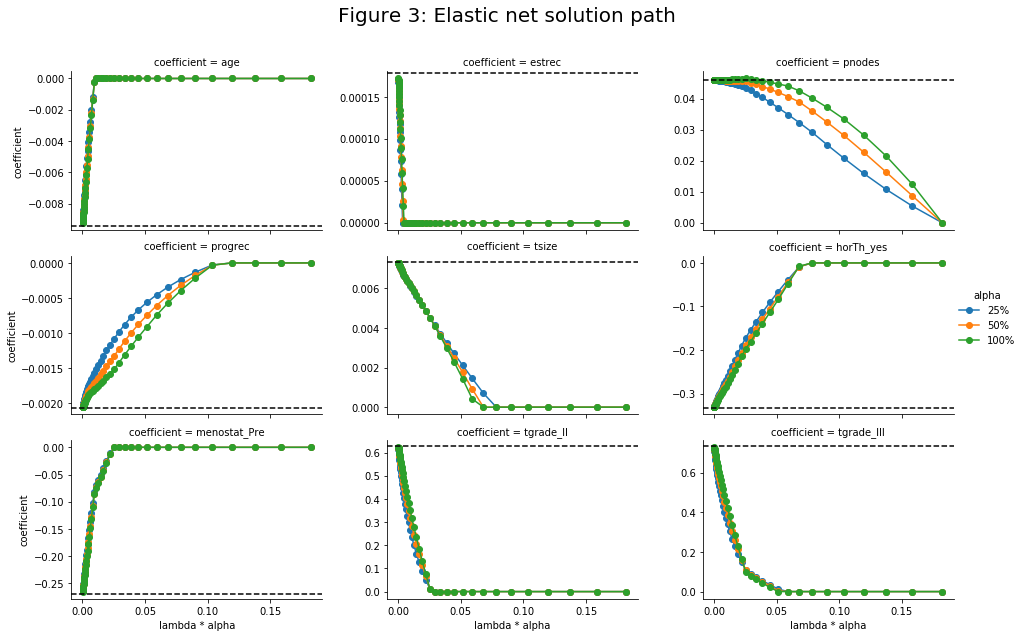

In [3]:
# Load in the German breast cancer dataset
url = "https://raw.githubusercontent.com/alonsosilvaallende/GBCSG2-dataset_Cox_RSF_GBC_DeepSurv/master/data/GBCSG2.csv"
df = pd.read_csv(url)
# time, censoring
tt_dd = [df.time.astype(int).values, np.where(df.event,1,0)]
# one-hot-encoded design matrix
df = pd.get_dummies(df.drop(columns=['time','event']),drop_first=True)
X = df.values

mdl_elnet = linear_wrapper(method='elnet')
holder = []
for aa in [0.25, 0.50, 1.0]:
    mdl_elnet.fit(data=X, lbls=tt_dd, alpha=aa)
    df_aa = pd.DataFrame(mdl_elnet.bhat,columns=mdl_elnet.lamseq)
    df_aa.index = np.append('intercept', df.columns)
    df_aa = df_aa.reset_index().melt('index',value_name='bhat',var_name='lam').assign(alpha = aa)
    holder.append(df_aa)
df_aa = pd.concat(holder).assign(lam_alpha = lambda x: x.lam * x.alpha)
ml = linear_wrapper(method='irls')
ml.fit(X,tt_dd)
df_ml = pd.DataFrame({'coefficient':df.columns,'ml':ml.bhat.flatten()[1:]})
df_aa = df_aa[~(df_aa['index']=='intercept')].rename(columns={'index':'coefficient'})

g = sns.FacetGrid(data=df_aa,col='coefficient',hue='alpha',col_wrap=3,height=3,aspect=1.5,sharey=False)
g.map(plt.plot,'lam_alpha','bhat',marker='o')
plt.subplots_adjust(top=0.88)
g.add_legend()
[z.set_text(t) for z,t in zip(g._legend.texts,['25%','50%','100%'])]
g.fig.suptitle(t='Figure 3: Elastic net solution path',fontsize=20)
g.set_xlabels('lambda * alpha'); g.set_ylabels('coefficient')
for ii,ax in enumerate(g.axes):
    ax.axhline(y=df_ml.loc[ii,'ml'],c='black',linestyle='dashed')